<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#preprocess" data-toc-modified-id="preprocess-1">preprocess</a></span></li><li><span><a href="#Recognizing-possible-characters" data-toc-modified-id="Recognizing-possible-characters-2">Recognizing possible characters</a></span></li><li><span><a href="#Recognizing-possible-plate" data-toc-modified-id="Recognizing-possible-plate-3">Recognizing possible plate</a></span></li><li><span><a href="#Generating-Plate-Objects" data-toc-modified-id="Generating-Plate-Objects-4">Generating Plate Objects</a></span></li><li><span><a href="#Converting-Graphical-Characters-into-String" data-toc-modified-id="Converting-Graphical-Characters-into-String-5">Converting Graphical Characters into String</a></span></li></ul></div>

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

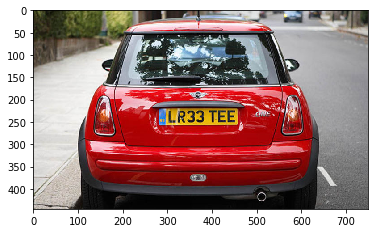

In [2]:
image=cv2.imread('./imgs/testMe.jpg')

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# preprocess
in this part, initially, we will use low frequency filters to eliminate noises.And then high frequency filters are used to find edges

- As the first step we will convert the picture into HSV color area to use it values.
- Next we use some of morphological transformations to increas the contrast of the image.
- At the end a Guassian filter is used to ommit the noise(Gaussian filter is known as a low pass filter)
- in the end we can use an adaptive thresholding in order find the edges
**NOTE:** The adaptive threshold transforms a grayscale image to a binary image according to the formulae:
$$
dst( x,y) =\begin{cases}
0 & if\ src( x,y)  >T( x,y)\\
255 & otherwise
\end{cases}
$$
Where $T(x,y)$ is a threshold calculated individually for each pixel.
he threshold value $T(x,y)$ is a weighted sum (cross-correlation with a Gaussian window) of the $\texttt{19} \times \texttt{19}$ neighborhood of $(x,y)$ minus 9.

structuringElement is:
[[1 1 1]
 [1 1 1]
 [1 1 1]]


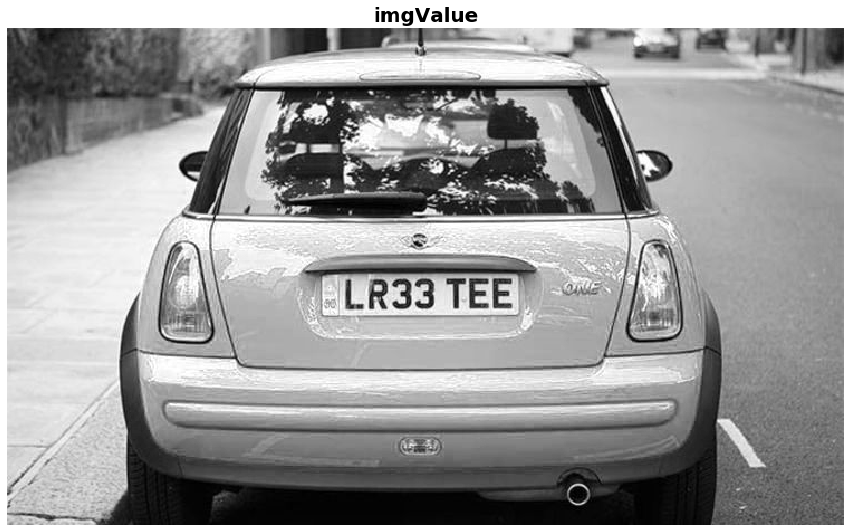

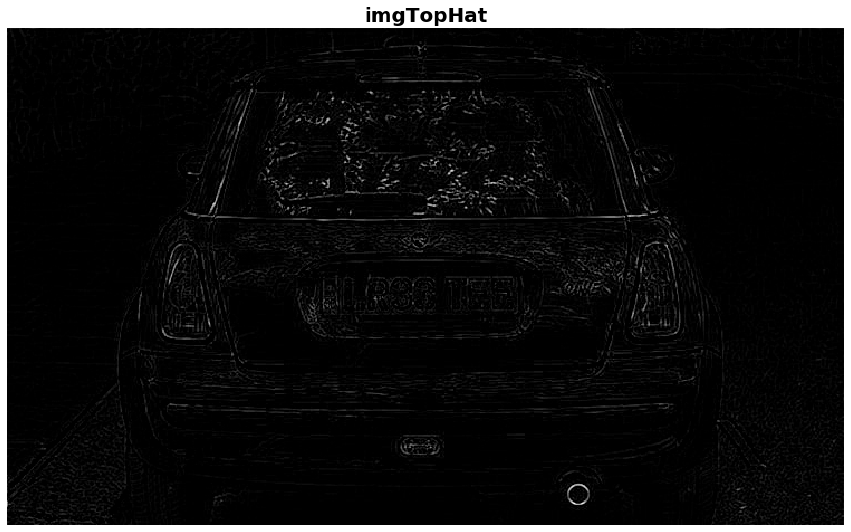

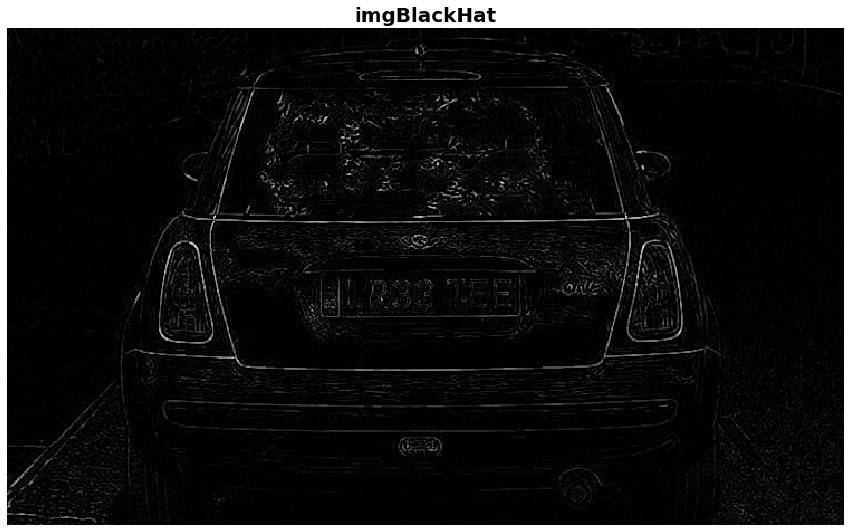

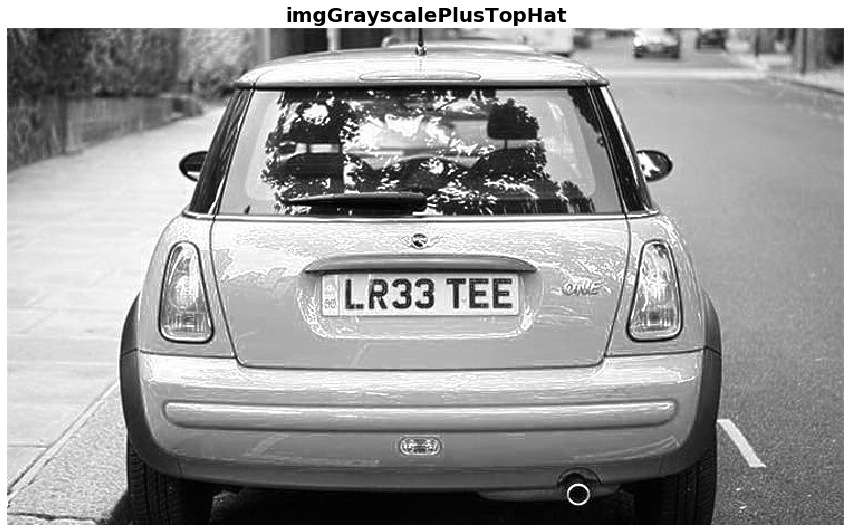

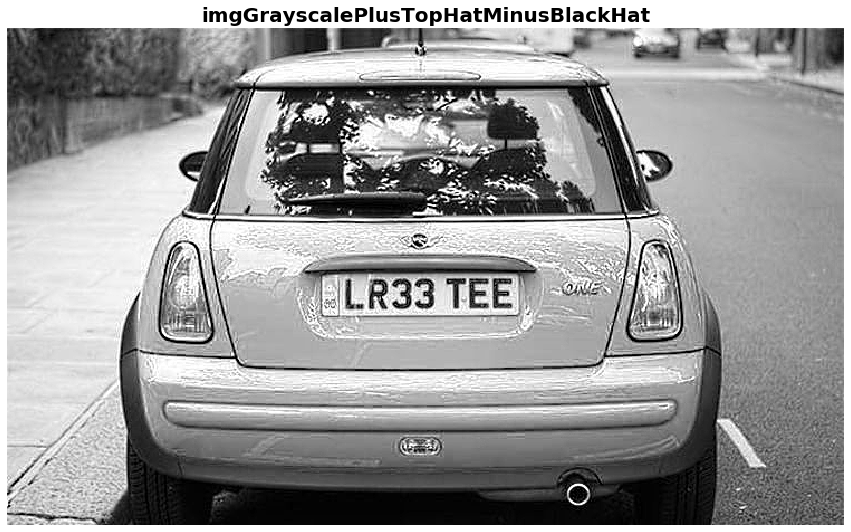

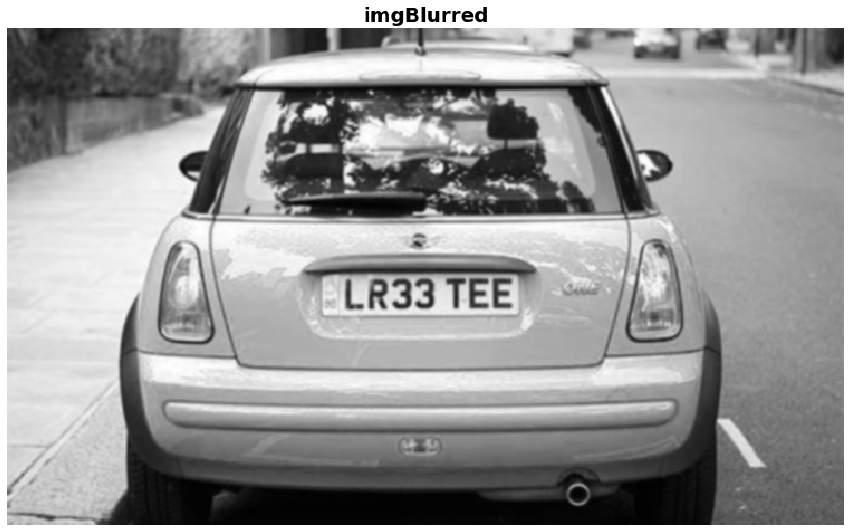

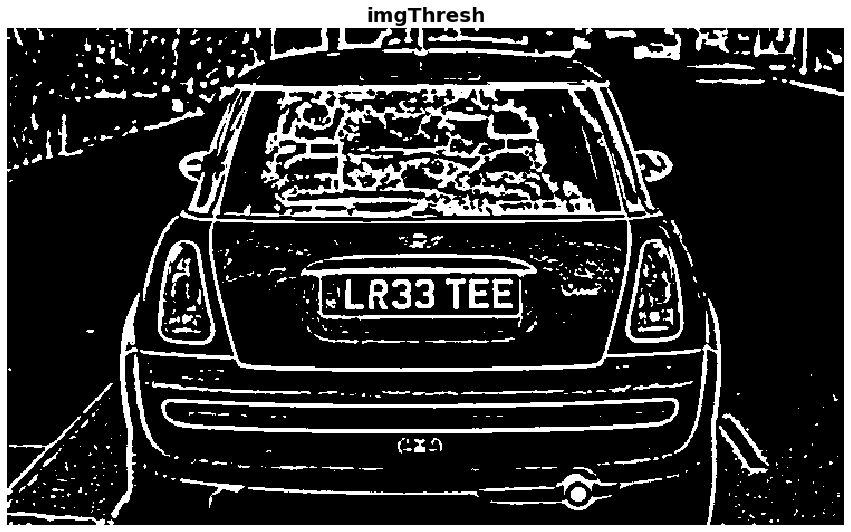

In [3]:
_,_,imgValue = cv2.split(cv2.cvtColor(image,cv2.COLOR_RGB2HSV))
structuringElement = np.ones((3, 3),np.uint8)
print("structuringElement is:\n",structuringElement,sep="")
imgTopHat = cv2.morphologyEx(imgValue, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(imgValue, cv2.MORPH_BLACKHAT, structuringElement)
imgGrayscalePlusTopHat = cv2.add(imgValue, imgTopHat)
imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)
imgBlurred = cv2.GaussianBlur(imgGrayscalePlusTopHatMinusBlackHat, (5,5), 0)
imgBlurred = cv2.GaussianBlur(imgValue, (5,5), 0)
imgThresh = cv2.adaptiveThreshold(imgBlurred, 
                                  255, 
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 
                                  19, 
                                  9)
# # # # # # # 
i=1
images2show=['imgValue',
            'imgTopHat',
            'imgBlackHat',
            'imgGrayscalePlusTopHat',
            'imgGrayscalePlusTopHatMinusBlackHat',
            'imgBlurred',
            'imgThresh']
for img in images2show:
#     plt.subplot(7,1,i)
#     i+=1
    plt.figure(figsize=(15,20))
    plt.imshow(eval(img),cmap='gray')
    plt.axis(False)
    plt.title(img,fontsize=20,fontweight='bold')
    plt.show()


# Recognizing possible characters
In this part we can use `cv2.findContours` functions to find the exact position of shapes.
> Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

the output is list of 672 elements, containing pixels position which each element introduces one single shape


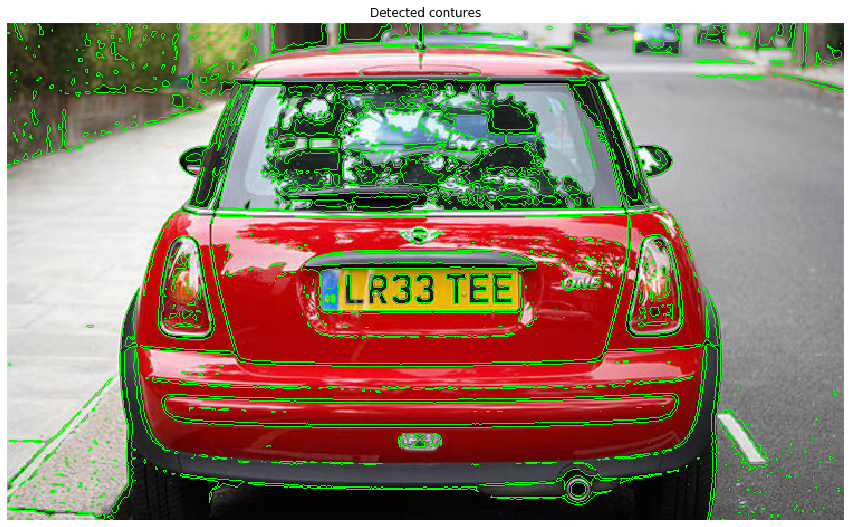

In [4]:
contours, npaHierarchy = cv2.findContours(imgThresh, 
                                          cv2.RETR_LIST, 
                                          cv2.CHAIN_APPROX_SIMPLE)
print(f"the output is list of {len(contours)} elements, containing pixels position which each element introduces one single shape")
imgContures=cv2.drawContours(image.copy(), contours, -1, (0,255,0), 1)
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(imgContures, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.title("Detected contures")
plt.show()

As a consequence of large number of shapes we will filter them using simple calculations to avoid overprocessing and save the time:
- The enclosed area must be more than 50 pixels
- each shape's width must be bigger than 2 pixels and the hight must be more than 8 pixels, otherwise the character can not recognized correctly due to lack of data to compare to other pixels
- the ratio of width over height must be bigger than 0.25 and must not exceed 2, otherwise the shape is too narrow of too wide to known as a single character

this calculations are implemented in `Char.py`file, in `character` class.so we should import it

In [5]:
from plateRecognizer import character
possibleChars=[]
for contour in contours:
    possibleChar = character(contour)
    if possibleChar.isValid():
        possibleChars.append(possibleChar)

the output is list of 78 elements, containing pixels position which each element introduces one single shape


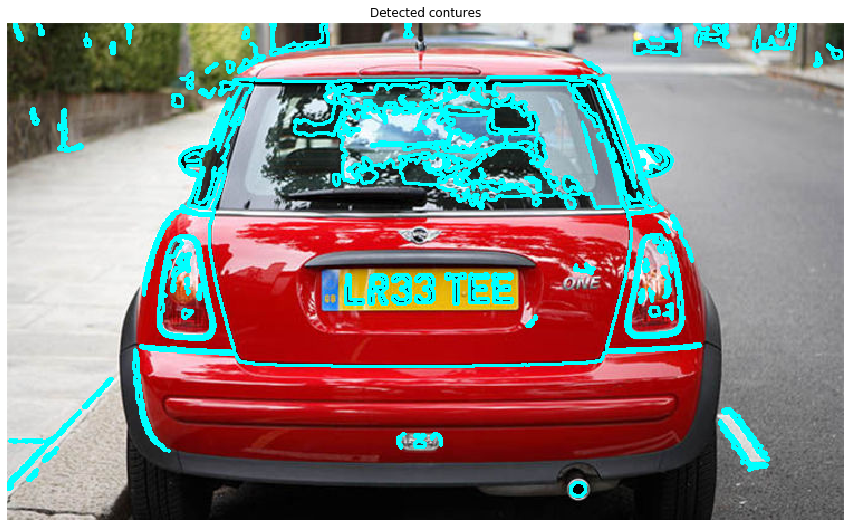

In [6]:
print(f"the output is list of {len(possibleChars)} elements, containing pixels position which each element introduces one single shape")
imgContures=cv2.drawContours(image.copy(), 
                             [i.contour for i in possibleChars], 
                             -1, 
                             (255,255,0), 
                             2)
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(imgContures, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.title("Detected contures")
plt.show()

# Recognizing possible plate
as a result of this simple filter most of shapes are ommited, But still there are number of shapes which can be removed easily.

As we search for the plates(and obviously characters are in the plates), each pair of characters should follow this conditions to put them in same group:
- the ratio of characters distance over the diameter of bounding rectangle must not exceed 8
> $distance( c_{1} ,c_{2}) =\sqrt{( {c_{1}}_{x} -{c_{2}}_{x})^{2} +( {c_{1}}_{y} -{c_{2}}_{y})^{2}}$
- Angle between connector line two charactes and horizontal line must not exceed 12 degrees(this will cause to lost diognal plates, which are quite rare)
> $atan2(|{c_{1}}_{y} -{c_{2}}_{y}|,|{c_{1}}_{x} -{c_{2}}_{x}|)$
- the ratio of two enclosed area of characters must fall between $\frac{2}{3}$ and $\frac{3}{2}$ in other words they can have only $50\%$ diefference in their area
- the ratio of two width of characters must fall between $\frac{5}{9}$ and $\frac{9}{5}$ in other words they can have only $80\%$ diefference in their width
- the ration of two height of characters must fall between $\frac{5}{6}$ and $\frac{6}{5}$ in other words they can have only $20\%$ diefference in their height

these calculations are available in `character` class
> **NOTE:** each character is used only in one group

After putting each character in single group, The group wich has less than 3 characters will be eliminated

In [7]:
groupedCahrs=[]

while possibleChars:
    currentChar=possibleChars.pop()
    currentGroup,possibleChars=currentChar.findNearChars(possibleChars)
    if len(currentGroup)>=2:
        currentGroup.append(currentChar)
        groupedCahrs.append(currentGroup)

4 groups detected
containing total 16 characters


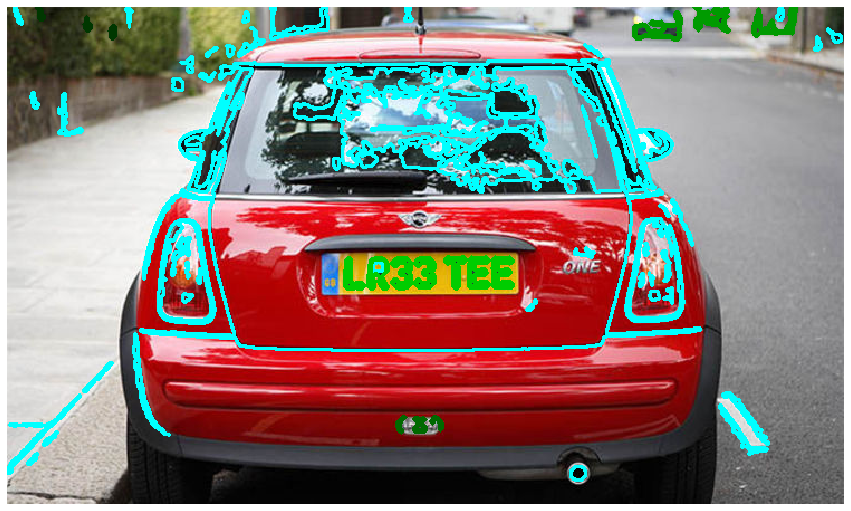

In [8]:
plt.figure(figsize=(15,10))
print(f"""{len(groupedCahrs)} groups detected
containing total {sum(len(i) for i in groupedCahrs)} characters""")
imgGrouped=imgContures.copy()
for i,g in enumerate(groupedCahrs):
    imgGrouped=cv2.drawContours(imgGrouped, 
                                [i.contour for i in g], 
                                -1, 
                                (0,55+i*200//len(groupedCahrs),0), 
                                3)
plt.imshow(cv2.cvtColor(imgGrouped, cv2.COLOR_BGR2RGB))
plt.axis(False)

plt.show()

# Generating Plate Objects
in the next step we will generate plate objects to calculate some factors for each plate.
- initialy we should sort the chars using their $X$ value
```python
chars.sort(key = lambda currentChar: currentChar.centerX)
```
- **position of center point** equals average of the first and last chars.
```python
self.centerX=int(chars[0].centerX+chars[-1].centerX)//2
self.centerY=int(chars[0].centerY+chars[-1].centerY)//2
self.center=(self.centerX,self.centerY)
```
- **plates width** equals half of last and first chars width, plus last char $X$ coordinate value, minus first char $X$ coordinate value
- **plate height** equals all chars height mean
> **NOTE:** we could use same approach for calculating plate width, but using this method we can invalidate plates, in which characters exceeds the plate borders.



In [9]:
from plateRecognizer import plate
plates=[plate(group,image) for group in groupedCahrs]

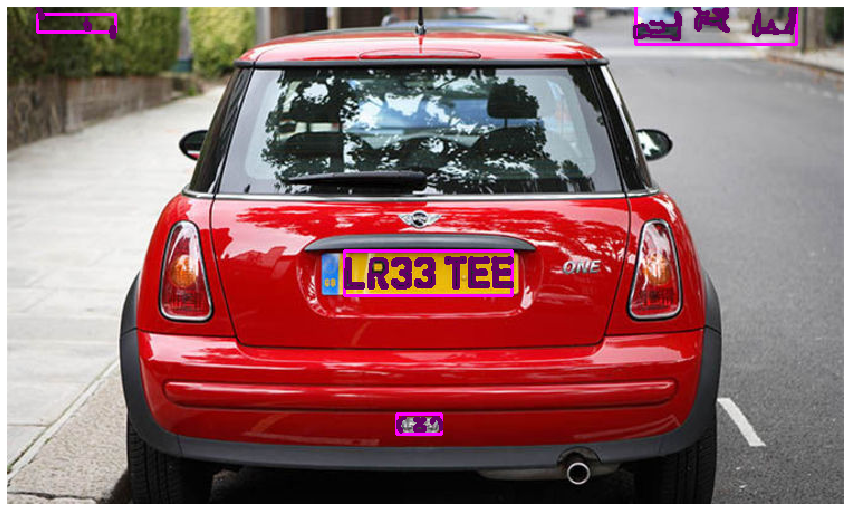

In [10]:
plateImg=image.copy()
for p in plates:
    cv2.rectangle(plateImg,
                  (p.center[0]-p.width//2,p.center[1]-p.height//2),
                  (p.center[0]+p.width//2,p.center[1]+p.height//2),
                  (255,0,255),
                  2)
    cv2.drawContours(plateImg,[i.contour for i in p.chars],-1,(100,0,100),2)
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(plateImg, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.show()

In this part we can omit some more characters:
- Characters wich goes beyond the plate border
- In each pair of characters the smaller character will be ommited if the ratio of their distance over the characters diameter exceeds $0.3$

each plate containing 3 or less characters will be disqualified

In [11]:
plates=[i for i in plates if i.isValid()]

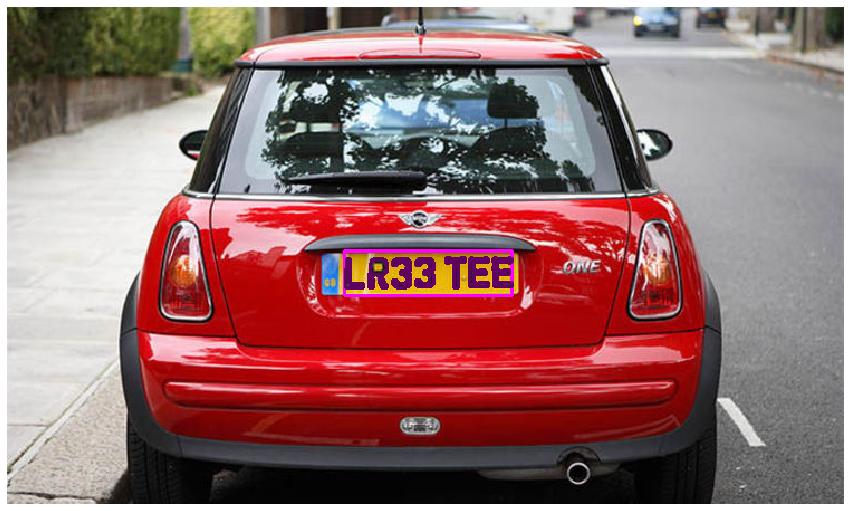

In [12]:
plateImg=image.copy()
for p in plates:
    cv2.rectangle(plateImg,
                  (p.center[0]-p.width//2,p.center[1]-p.height//2),
                  (p.center[0]+p.width//2,p.center[1]+p.height//2),
                  (255,0,255),
                  2)
    cv2.drawContours(plateImg,[i.contour for i in p.chars],-1,(100,0,100),2)
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(plateImg, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.show()


# Converting Graphical Characters into String
After recognizing the plate we can use OCR methods to convert the characters into string.
We will use KNN approach to find the most similar letter to characters.

In [13]:
KNNmodel = cv2.ml.KNearest_create()
classes = np.loadtxt("./plateRecognizer/classifications.txt",
                     np.float32).reshape((-1,1))
flattenImages = np.loadtxt("./plateRecognizer/flattened_images.txt",
                            np.float32)
KNNmodel.setDefaultK(len(set(classes.ravel())))
KNNmodel.train(flattenImages, cv2.ml.ROW_SAMPLE, classes)
print("classes are:",*[chr(i) for i in set(classes.ravel())])

classes are: 0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z


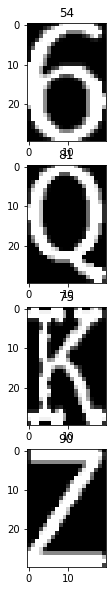

In [14]:
# show some of the train pictures
testIndex=[175,158,87,0]
i=1
plt.figure(figsize=(len(testIndex)*15,10))
for t in testIndex:
    plt.subplot(len(testIndex),1,i)
    i+=1
    plt.imshow(flattenImages[t].reshape((30,20)),cmap='gray')
    plt.title(str(int(classes[t][0])))
plt.show()

Next we can simply seperate each character and search for the most similar picture in the `flattenImages`

In [15]:
strChars=''
RESIZED_CHAR_IMAGE_WIDTH = 20
RESIZED_CHAR_IMAGE_HEIGHT = 30
for currentChar in plates[0].chars:
    currentChar.imgThresh = imgThresh[currentChar.boundingRectY : currentChar.boundingRectY + currentChar.height,
                                      currentChar.boundingRectX : currentChar.boundingRectX + currentChar.width]

    currentChar.imgThresh=cv2.resize(currentChar.imgThresh,
                                     (RESIZED_CHAR_IMAGE_WIDTH,
                                     RESIZED_CHAR_IMAGE_HEIGHT))\
                          .reshape((1,-1))\
                          .astype(np.float32)

    res=int(KNNmodel.findNearest(currentChar.imgThresh, k = 1)[1][0][0])
    strChars+=chr(res)
print(strChars)

LR33TEE


In [16]:
print('finished :)')

finished :)
